<a href="https://colab.research.google.com/github/praveenbommalibits/salary-prediction-app/blob/master/HousePrediction_FeatureEngeering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

House Prices -Advanced regression techiniques -  end to end example and in detailed feature engineering was applied 

# Imports and Configurations

In [3]:
import os 
import warnings 
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

!pip install category_encoders  
from category_encoders import MEstimateEncoder # Encoding the all the categorical columns 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

#Set Matplotlib defaults
plt.style.use('seaborn-whitegrid')
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10
)

# Stopping warnings 

warnings.filterwarnings('ignore')


     |████████████████████████████████| 81kB 8.3MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data preprocessing
- Load - load data from CSV file 
- Clean - fix the errors and inconsistencies
- Encode - the statistical data type(numeric and categorical)
- Impute - any missing values handling 
  

## Load

In [20]:
def load_data():
  # read data 
  data_dir = Path("/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques/")
  df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
  df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")

  # merege the train and test data and process together 
  df = pd.concat([df_train, df_test])

  #Preprocessing 
  df = clean(df)
  df = encode(df)
  df = impute(df)

  # reform splits
  df_train = df.loc[df_train.index, :]
  df_test = df.loc[df_test.index, :]
  return df_train, df_test


## *Clean*


In [8]:
data_dir = Path("/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques")
df = pd.read_csv(data_dir / "train.csv", index_col="Id")
df.head()
#print(df._get_numeric_data.columns)
#df.Exterior2nd.unique()
#print(df.)
print(df.select_dtypes(include=['object']).columns.tolist())

df.head()

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
def clean(df):
  df['Exterior2nd'] = df["Exterior2nd"].replace({"Brk Cmn":"Brk Comm"})
  # some values of GarageYrBlt are corrupt , so we'll replace them with the year the house built 
  df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)

  # updated the names of columns. 
  df.rename(columns = {
      "1stFlrSF": "FirstFlrSF",
      "2ndFlrSF": "SecondFlrSF",
      "3SsnPorch": "Threeseasonporch",
  }, inplace=True,)
  return df


# Encode - the statistical data type

In [10]:
# numeric features already encoded like float - continuous  and int - discrete
# categorical need to be done from our side 


# the nominative (unordered) categorical feature
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", 
                "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st",
                "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", 
                "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}



def encode(df):
  # Nominal categories
  for name in features_nom:
    df[name] = df[name].astype("category")
    #Add a None category for missing Values 
    if "None" not in df[name].cat.categories:
      df[name].cat.add_categories("None", inplace=True)

  # Ordinal Categories. 
  for name, levels in ordered_levels.items():
    df[name] = df[name].astype(CategoricalDtype(levels, ordered=True))

  return df




## Impute :Handling missing values
#### Impute 0 - for missing numerical values
#### Impute "None" - for missing categorical values 

In [11]:
def impute(df):
  for name in df.select_dtypes("number"):
    df[name] = df[name].fillna(0)
  for name in df.select_dtypes("category"):
    df[name] = df[name].fillna("None")
  return df


All Preprocessing steps on data was completed. Now time to load the data test and process. Same process we can apply for any kind of dataset 

Load Data

In [21]:
df_train, df_test = load_data()

In [22]:
# Peek at the values. 
display(df_train)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,FirstFlrSF,SecondFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,Threeseasonporch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,953.0,953.0,GasA,Ex,Y,SBrkr,953,694,0,1647,0.0,0.0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2.0,460.0,TA,TA,Y,0,40,0,0,0,0,None,None,None,0,8,2007,WD,Normal,175000.0
1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790.0,Rec,163.0,589.0,1542.0,GasA,TA,Y,SBrkr,2073,0,0,2073,1.0,0.0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2.0,500.0,TA,TA,Y,349,0,0,0,0,0,None,MnPrv,None,0,2,2010,WD,Normal,210000.0
1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275.0,Unf,0.0,877.0,1152.0,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0.0,0.0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1.0,252.0,TA,TA,Y,0,60,0,0,0,

In [23]:
display(df_test)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,FirstFlrSF,SecondFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,Threeseasonporch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,None,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,None,MnPrv,None,0,6,2010,WD,Normal,0.0
1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,None,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,None,None,Gar2,12500,6,2010,WD,Normal,0.0
1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,None,MnPrv,None,0,3,2010,WD,Normal,0.0
1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,None,None,None,0,6,2010,WD,Normal,0.0
1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,None,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,None,None,None,0,1,2010,WD,Normal,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,None,None,1970.0,None,0.0,0.0,None,None,Y,0,0,0,0,0,0,None,None,None,0,6,2006,WD,Normal,0.0
2916,160,RM,21.0,1894,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,None,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,None,None,None,0,4,2006,WD,Abnorml,0.0
2917,20,RL,160.0,20000,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,None,

In [25]:
display(df_train.info())
#display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1460 non-null   category
 1   MSZoning          1460 non-null   category
 2   LotFrontage       1460 non-null   float64 
 3   LotArea           1460 non-null   int64   
 4   Street            1460 non-null   category
 5   Alley             1460 non-null   category
 6   LotShape          1460 non-null   category
 7   LandContour       1460 non-null   category
 8   Utilities         1460 non-null   category
 9   LotConfig         1460 non-null   category
 10  LandSlope         1460 non-null   category
 11  Neighborhood      1460 non-null   category
 12  Condition1        1460 non-null   category
 13  Condition2        1460 non-null   category
 14  BldgType          1460 non-null   category
 15  HouseStyle        1460 non-null   category
 16  OverallQual       1460 n

None

In [26]:
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1459 non-null   category
 1   MSZoning          1459 non-null   category
 2   LotFrontage       1459 non-null   float64 
 3   LotArea           1459 non-null   int64   
 4   Street            1459 non-null   category
 5   Alley             1459 non-null   category
 6   LotShape          1459 non-null   category
 7   LandContour       1459 non-null   category
 8   Utilities         1459 non-null   category
 9   LotConfig         1459 non-null   category
 10  LandSlope         1459 non-null   category
 11  Neighborhood      1459 non-null   category
 12  Condition1        1459 non-null   category
 13  Condition2        1459 non-null   category
 14  BldgType          1459 non-null   category
 15  HouseStyle        1459 non-null   category
 16  OverallQual       145

None

# Establish the baseline 
Generate the score to understand the feature engineering requirement on the original data set. 


In [36]:
def score_dataset(X, y, model=XGBRegressor()):
  #Label encoding for categoricals
  # Label encoding - good for XGBoost and Random Forest
  # One-hot encoding -  good for Lasso or Ridge
  # cat.codes - holds category levels

  for colname in X.select_dtypes(["category"]):
    X[colname] = X[colname].cat.codes
  #Metrics - for Housing competition is RMSLE
  log_y = np.log(y)
  score = cross_val_score(model,  X, log_y, cv=5, scoring="neg_mean_squared_error",)
  score = -1 * score.mean()
  score = np.sqrt(score)
  return score



In [37]:
# Run the processed data with no additional features and get a baseline score
X = df_train.copy()
y = X.pop("SalePrice")
len(X.columns)

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")


[13:06:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:06:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:06:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:06:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:06:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Baseline score: 0.12994 RMSLE


# Feature Utility scores

In [38]:
def make_mi_scores(X, y):
  X = X.copy()
  for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()
  # All discrete features should have integer dtypes
  discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
  mi_scores = mutual_info_regression(X, y, discrete_features= discrete_features, random_state=0)
  mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
  return mi_scores

def plot_mi_scores(scores):
  scores = scores.sort_values(ascending=True)
  width = np.arange(len(score))
  ticks = list(scores.index)
  plt.barh(width, scores)
  plt.yticks(width, ticks)
  plt.title("Mutual Information Scores")
 


Calculate Score again 

In [39]:
X = df_train.copy()
y = X.pop("SalePrice")
mi_scores = make_mi_scores(X, y)
mi_scores  

MSSubClass       0.281349
MSZoning         0.128241
LotFrontage      0.218588
LotArea          0.394468
Street           0.000610
                   ...   
MiscVal          0.000000
MoSold           0.000000
YrSold           0.000000
SaleType         0.080337
SaleCondition    0.080339
Name: MI Scores, Length: 79, dtype: float64

Features with less mutual information or less/zero score need to be drop

In [41]:
def drop_uninformative(df, mi_scores):
  return df.loc[:, mi_scores > 0.0]

X = df_train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)
score_dataset(X, y)

[15:13:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.12983724201925587

# Creates Features


Now we'll start developing our feature set.

To make our feature engineering workflow more modular, we'll define a function that will take a prepared dataframe and pass it through a pipeline of transformations to get the final feature set. It will look something like this:

<p> def create_features(df):

    X = df.copy()
    y = X.pop("SalePrice")
    X = X.join(create_features_1(X))
    X = X.join(create_features_2(X))
    X = X.join(create_features_3(X))
    # ...
    return X 
</p>
Let's go ahead and define one transformation now, a label encoding for the categorical features:

In [53]:
# Define the label encoding for for the categorical features. 
def label_encode(df):
  X = df.copy()
  for colname in X.select_dtypes(["category"]):
    X[colname] = X[colname].cat.codes
  return X


A label encoding is okay for any kind of categorical feature when you're using a tree-ensemble like XGBoost, even for unordered categories. If you wanted to try a linear regression model (also popular in this competition), you would instead want to use a one-hot encoding, especially for the features with unordered categories.

# Create Features with Pandas 


In [42]:
def mathematical_transforms(df):
  X = pd.DataFrame() # data frame to hold new features. 
  X["LivLotRatio"] = df.GrLivArea / df.LotArea
  X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd

  return X

def interactions(df):
  X = pd.get_dummies(df.BldgType, prefix="Bldg")
  X = X.mul(df.GrLivArea, axis=0)
  return X

def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X


def break_down(df):
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X


def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X

Here are some ideas for other transforms you could explore:

- Interactions between the quality Qual and condition Cond features. OverallQual, for instance, was a high-scoring feature. You could try combining it with OverallCond by converting both to integer type and taking a product.
- Square roots of area features. This would convert units of square feet to just feet.
- Logarithms of numeric features. If a feature has a skewed distribution, applying a logarithm can help normalize it.
- Interactions between numeric and categorical features that describe the same thing. You could look at interactions between BsmtQual and TotalBsmtSF, for instance.
- Other group statistics in Neighboorhood. We did the median of GrLivArea. Looking at mean, std, or count could be interesting. You could also try combining the group statistics with other features. Maybe the difference of GrLivArea and the median is important?

#k-Means Clustering
The first unsupervised algorithm we used to create features was k-means clustering. We saw that you could either use the cluster labels as a feature (a column with 0, 1, 2, ...) or you could use the distance of the observations to each cluster. We saw how these features can sometimes be effective at untangling complicated spatial relationships.

In [46]:
cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new

def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

# Principal Component Analysis
PCA was the second unsupervised model we used for feature creation. We saw how it could be used to decompose the variational structure in the data. The PCA algorithm gave us loadings which described each component of variation, and also the components which were the transformed datapoints. The loadings can suggest features to create and the components we can use as features directly.

Here are the utility functions from the PCA lesson:

In [ ]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


*And here are transforms that produce the features from the Exercise 5. You might want to change these if you came up with a different answer.*

In [47]:
def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

These are only a couple ways you could use the principal components. You could also try clustering using one or more components. One thing to note is that PCA doesn't change the distance between points -- it's just like a rotation. So clustering with the full set of components is the same as clustering with the original features. Instead, pick some subset of components, maybe those with the most variance or the highest MI scores.

For further analysis, you might want to look at a correlation matrix for the dataset:

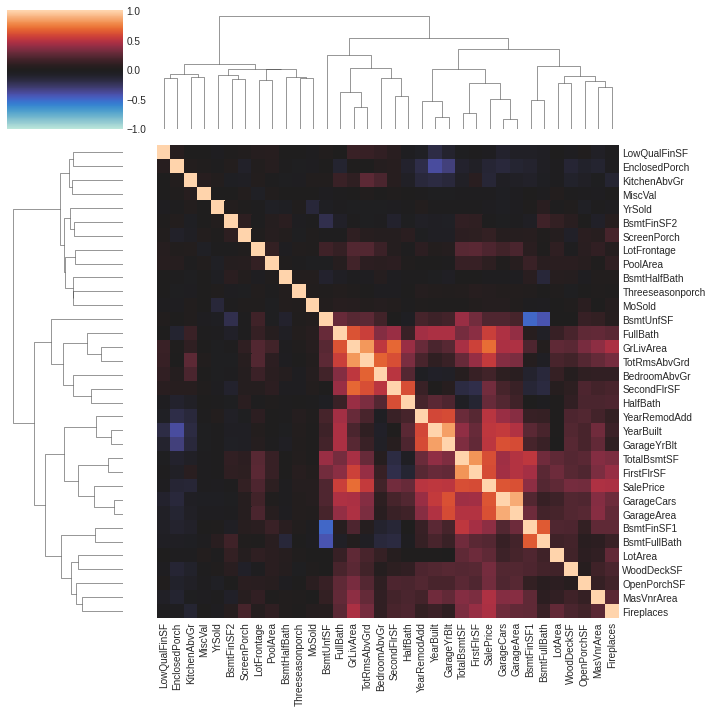

In [48]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None)

Groups of highly correlated features often yield interesting loadings.

# PCA Application - Indicate Outliers

In Exercise 5, you applied PCA to determine houses that were outliers, that is, houses having values not well represented in the rest of the data. You saw that there was a group of houses in the Edwards neighborhood having a SaleCondition of Partial whose values were especially extreme.

Some models can benefit from having these outliers indicated, which is what this next transform will do.

In [49]:
def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial")
    return X_new

You could also consider applying some sort of robust scaler from scikit-learn's sklearn.preprocessing module to the outlying values, especially those in GrLivArea. Here is a tutorial illustrating some of them. Another option could be to create a feature of "outlier scores" using one of scikit-learn's outlier detectors.

# Target Encoding
Needing a separate holdout set to create a target encoding is rather wasteful of data. In Tutorial 6 we used 25% of our dataset just to encode a single feature, Zipcode. The data from the other features in that 25% we didn't get to use at all.

There is, however, a way you can use target encoding without having to use held-out encoding data. It's basically the same trick used in cross-validation:

Split the data into folds, each fold having two splits of the dataset.
Train the encoder on one split but transform the values of the other.
Repeat for all the splits.
This way, training and transformation always take place on independent sets of data, just like when you use a holdout set but without any data going to waste.

In the next hidden cell is a wrapper you can use with any target encoder:

In [50]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

Use it like:

encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
X_encoded = encoder.fit_transform(X, y, cols=["MSSubClass"]))
You can turn any of the encoders from the category_encoders library into a cross-fold encoder. The CatBoostEncoder would be worth trying. It's similar to MEstimateEncoder but uses some tricks to better prevent overfitting. Its smoothing parameter is called a instead of m.



# Create Final Feature Set
Now let's combine everything together. Putting the transformations into separate functions makes it easier to experiment with various combinations. The ones I left uncommented I found gave the best results. You should experiment with you own ideas though! Modify any of these transformations or come up with some of your own to add to the pipeline.

In [54]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Lesson 2 - Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Lesson 3 - Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    # X = X.join(break_down(X))
    X = X.join(group_transforms(X))

    # Lesson 4 - Clustering
    # X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    # X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

    # Lesson 5 - PCA
    X = X.join(pca_inspired(X))
    # X = X.join(pca_components(X, pca_features))
    # X = X.join(indicate_outliers(X))

    X = label_encode(X)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Lesson 6 - Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X


df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

score_dataset(X_train, y_train)

[16:03:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:03:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:03:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:03:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:03:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.1296470541819097

# Hyperparameter Tuning
At this stage, you might like to do some hyperparameter tuning with XGBoost before creating your final submission.

In [56]:
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

xgb_params = dict(
    max_depth=6,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

[16:04:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:04:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:04:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:04:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:04:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.12414980369744023

Just tuning these by hand can give you great results. However, you might like to try using one of scikit-learn's automatic hyperparameter tuners. Or you could explore more advanced tuning libraries like Optuna or scikit-optimize.

Here is how you can use Optuna with XGBoost:

In [58]:
!pip install optuna
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params

     |████████████████████████████████| 307kB 27.8MB/s 
     |████████████████████████████████| 174kB 33.7MB/s 
     |████████████████████████████████| 81kB 7.9MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 143kB 39.7MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
     |████████████████████████████████| 112kB 31.4MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11136 sha256=d3afc49021d5aaac803e64d30c5a9e8e550da2940cc6f844c8699d2eda40a0ac
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


[I 2021-06-19 16:10:13,956] A new study created in memory with name: no-name-40af5a74-edbd-4cc9-a1c9-4c83d7ea0b0f


[16:10:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:10:55,737] Trial 0 finished with value: 0.13016191554520645 and parameters: {'max_depth': 2, 'learning_rate': 0.02198117646327942, 'n_estimators': 5634, 'min_child_weight': 10, 'colsample_bytree': 0.8575872650732121, 'subsample': 0.9883455221157516, 'reg_alpha': 3.2975413640747533, 'reg_lambda': 0.003798039042279432}. Best is trial 0 with value: 0.13016191554520645.


[16:10:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:12:13,696] Trial 1 finished with value: 0.41439714599849653 and parameters: {'max_depth': 2, 'learning_rate': 0.00045292456120514106, 'n_estimators': 7495, 'min_child_weight': 5, 'colsample_bytree': 0.7029234163269535, 'subsample': 0.5609881331871206, 'reg_alpha': 0.00028373757541486804, 'reg_lambda': 0.002794859912721556}. Best is trial 0 with value: 0.13016191554520645.


[16:12:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:13:01,011] Trial 2 finished with value: 0.12430511047059642 and parameters: {'max_depth': 5, 'learning_rate': 0.00874670820475331, 'n_estimators': 4934, 'min_child_weight': 6, 'colsample_bytree': 0.27709420357613435, 'subsample': 0.44104264768678414, 'reg_alpha': 2.165729527753782, 'reg_lambda': 0.009569391755081846}. Best is trial 2 with value: 0.12430511047059642.


[16:13:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:14:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:14:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:15:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:15:38,975] Trial 3 finished with value: 4.70020847881457 and parameters: {'max_depth': 6, 'learning_rate': 0.0001687787210752719, 'n_estimators': 5320, 'min_child_weight': 1, 'colsample_bytree': 0.9396553954378539, 'subsample': 0.9172505887780054, 'reg_alpha': 0.009230720354286872, 'reg_lambda': 0.004136851777297424}. Best is trial 2 with value: 0.12430511047059642.


[16:15:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:15:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:15:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:15:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:15:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:15:55,627] Trial 4 finished with value: 5.467030769639611 and parameters: {'max_depth': 4, 'learning_rate': 0.00025009909342412954, 'n_estimators': 3013, 'min_child_weight': 4, 'colsample_bytree': 0.5284353568567692, 'subsample': 0.4084948379753674, 'reg_alpha': 25.685950609199246, 'reg_lambda': 0.019295516323793133}. Best is trial 2 with value: 0.12430511047059642.


[16:15:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:16:07,507] Trial 5 finished with value: 7.657225744127729 and parameters: {'max_depth': 5, 'learning_rate': 0.00020626794439173132, 'n_estimators': 2008, 'min_child_weight': 10, 'colsample_bytree': 0.7007466874768351, 'subsample': 0.9209341005097296, 'reg_alpha': 0.09155207781629615, 'reg_lambda': 10.701468982538463}. Best is trial 2 with value: 0.12430511047059642.


[16:16:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:16:41,303] Trial 6 finished with value: 0.34131130658997433 and parameters: {'max_depth': 9, 'learning_rate': 0.0017068565644185374, 'n_estimators': 2203, 'min_child_weight': 1, 'colsample_bytree': 0.8780366711642895, 'subsample': 0.32503069268980567, 'reg_alpha': 0.0008807645771238357, 'reg_lambda': 3.0915348933411404}. Best is trial 2 with value: 0.12430511047059642.


[16:16:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:17:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:17:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:17:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:18:12,872] Trial 7 finished with value: 1.7328990368692236 and parameters: {'max_depth': 9, 'learning_rate': 0.0002743500237667383, 'n_estimators': 6946, 'min_child_weight': 4, 'colsample_bytree': 0.9824835115428601, 'subsample': 0.8731606779039884, 'reg_alpha': 0.006642120016961645, 'reg_lambda': 0.7173788385615241}. Best is trial 2 with value: 0.12430511047059642.


[16:18:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:18:49,396] Trial 8 finished with value: 0.165118017554955 and parameters: {'max_depth': 8, 'learning_rate': 0.09381554496960604, 'n_estimators': 4056, 'min_child_weight': 1, 'colsample_bytree': 0.9998365705714021, 'subsample': 0.6165387681905383, 'reg_alpha': 10.550066977396892, 'reg_lambda': 32.23028250749084}. Best is trial 2 with value: 0.12430511047059642.


[16:18:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:19:01,534] Trial 9 finished with value: 0.3460560397138337 and parameters: {'max_depth': 8, 'learning_rate': 0.002863544970918093, 'n_estimators': 1631, 'min_child_weight': 10, 'colsample_bytree': 0.5719153005230792, 'subsample': 0.306138616389564, 'reg_alpha': 29.66369627708342, 'reg_lambda': 0.007868255377949345}. Best is trial 2 with value: 0.12430511047059642.


[16:19:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:19:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:19:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:19:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:19:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:19:36,592] Trial 10 finished with value: 0.12011245907882498 and parameters: {'max_depth': 4, 'learning_rate': 0.014775949575270411, 'n_estimators': 4214, 'min_child_weight': 7, 'colsample_bytree': 0.20396570719334733, 'subsample': 0.5761462182202688, 'reg_alpha': 0.7672780834589505, 'reg_lambda': 0.0001930838517588431}. Best is trial 10 with value: 0.12011245907882498.


[16:19:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:19:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:19:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:19:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:20:13,993] Trial 11 finished with value: 0.11975885673446982 and parameters: {'max_depth': 4, 'learning_rate': 0.014675042327509217, 'n_estimators': 4129, 'min_child_weight': 7, 'colsample_bytree': 0.23044766336719472, 'subsample': 0.565948455048119, 'reg_alpha': 0.69691246411264, 'reg_lambda': 0.00012451037523024644}. Best is trial 11 with value: 0.11975885673446982.


[16:20:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:20:40,359] Trial 12 finished with value: 0.11883248056810185 and parameters: {'max_depth': 3, 'learning_rate': 0.043195451235428416, 'n_estimators': 3842, 'min_child_weight': 7, 'colsample_bytree': 0.20490231948891746, 'subsample': 0.7138683997505557, 'reg_alpha': 0.2133271900666456, 'reg_lambda': 0.00010127196712072835}. Best is trial 12 with value: 0.11883248056810185.


[16:20:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:21:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:21:12,263] Trial 13 finished with value: 0.12297351088024296 and parameters: {'max_depth': 3, 'learning_rate': 0.09202700617298305, 'n_estimators': 3498, 'min_child_weight': 8, 'colsample_bytree': 0.36289079071836894, 'subsample': 0.7487876513572925, 'reg_alpha': 0.1595378199151487, 'reg_lambda': 0.0001032501689715357}. Best is trial 12 with value: 0.11883248056810185.


[16:21:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:21:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:21:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:21:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:22:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:22:12,846] Trial 14 finished with value: 0.11965070474078195 and parameters: {'max_depth': 3, 'learning_rate': 0.03765461630392711, 'n_estimators': 6163, 'min_child_weight': 8, 'colsample_bytree': 0.4155870921325894, 'subsample': 0.7740413451550008, 'reg_alpha': 0.1745052073260229, 'reg_lambda': 0.0003702941786883386}. Best is trial 12 with value: 0.11883248056810185.


[16:22:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:22:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:22:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:22:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:22:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:22:58,286] Trial 15 finished with value: 0.12030164222813793 and parameters: {'max_depth': 2, 'learning_rate': 0.033587636266184294, 'n_estimators': 6315, 'min_child_weight': 8, 'colsample_bytree': 0.39828095286442833, 'subsample': 0.7271636711709382, 'reg_alpha': 0.03475608137998515, 'reg_lambda': 0.00030970790841056925}. Best is trial 12 with value: 0.11883248056810185.


[16:22:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:23:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:23:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:23:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:24:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:24:20,109] Trial 16 finished with value: 0.12125473031923008 and parameters: {'max_depth': 6, 'learning_rate': 0.04503456922965723, 'n_estimators': 5990, 'min_child_weight': 8, 'colsample_bytree': 0.4634789308908446, 'subsample': 0.7600228785748842, 'reg_alpha': 0.22855197862652357, 'reg_lambda': 0.000980961746357327}. Best is trial 12 with value: 0.11883248056810185.


[16:24:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:24:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:24:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:24:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:24:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:24:43,392] Trial 17 finished with value: 0.1218375131227868 and parameters: {'max_depth': 3, 'learning_rate': 0.005497775016493239, 'n_estimators': 2953, 'min_child_weight': 9, 'colsample_bytree': 0.3134660442264149, 'subsample': 0.8182793017046225, 'reg_alpha': 0.01447144257252354, 'reg_lambda': 0.08850257473801373}. Best is trial 12 with value: 0.11883248056810185.


[16:24:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:24:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:26:04,873] Trial 18 finished with value: 0.12030969997660522 and parameters: {'max_depth': 3, 'learning_rate': 0.0493497064189471, 'n_estimators': 7796, 'min_child_weight': 6, 'colsample_bytree': 0.45742533891798953, 'subsample': 0.6632108026022934, 'reg_alpha': 0.0020704510932893993, 'reg_lambda': 0.0006350555867433318}. Best is trial 12 with value: 0.11883248056810185.


[16:26:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-06-19 16:26:56,101] Trial 19 finished with value: 0.12066829677351912 and parameters: {'max_depth': 7, 'learning_rate': 0.07669788313443227, 'n_estimators': 6613, 'min_child_weight': 3, 'colsample_bytree': 0.2039531979372995, 'subsample': 0.6766875946093238, 'reg_alpha': 0.052523787156334455, 'reg_lambda': 0.3018103623573506}. Best is trial 12 with value: 0.11883248056810185.


Copy this into a code cell if you'd like to use it, but be aware that it will take quite a while to run. After it's done, you might enjoy using some of Optuna's visualizations.

# Train Model and Create Submissions
Once you're satisfied with everything, it's time to create your final predictions! This cell will:

create your feature set from the original data
train XGBoost on the training data
use the trained model to make predictions from the test set
save the predictions to a CSV file

In [59]:
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

xgb = XGBRegressor(**xgb_params)
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
xgb.fit(X_train, np.log(y))
predictions = np.exp(xgb.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

[16:26:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Your submission was successfully saved!
